In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
# 데이터셋에서 사용할 데이터만 뽑아오는 함수
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [3]:
# 데이터셋 불러오기
cifar10 = tf.keras.datasets.cifar10

(train_x, test_x) = load_data(6)

train_x.shape

(5000, 32, 32, 3)

In [4]:
# 픽셀 값 확인
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
# 데이터셋의 shape 확인
train_x.shape

(5000, 32, 32, 3)

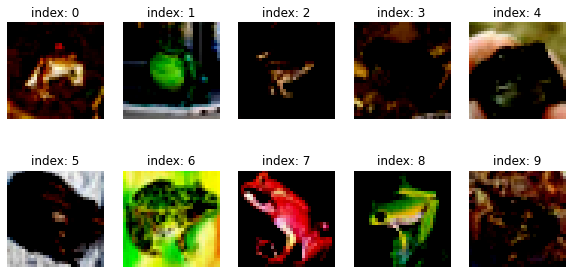

In [7]:
# 10개 데이터 확인
plt.figure(figsize=(10, 5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(train_x[i])
  plt.title(f'index: {i}')
  plt.axis('off')
plt.show()

In [8]:
# 텐서플로우의 Dataset을 이용해 준비
BUFFER_SIZE = 50000 # BUFFER_SIZE은 전체 데이터를 섞기 위해 60,000으로 설정
BATCH_SIZE = 256 # BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# 모델 구현
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
# 생성 모델을 generator라는 변수로 생성
# 모델 세부 내용인 summary를 출력
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [11]:
# 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터
noise = tf.random.normal([1, 100])

In [12]:
# 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성
generated_image = generator(noise, training=False) # 지금은 학습하는 중이 아니니 training=False를 설정
generated_image.shape

TensorShape([1, 32, 32, 3])

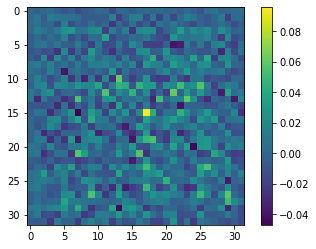

In [13]:
# 이미지 시각화
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [14]:
# 판별자 설계
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
# 판별 모델을 discriminator라는 변수 이름으로 생성
# 모델 세부 내용인 summary를 출력
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [16]:
# 아까 생성했던 가짜 이미지를 판별자에 입력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00377334]], dtype=float32)>

In [17]:
#  판별자가 판별한 값을 0~1 사이의 값으로 정규화한 후 알맞게 계산
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
# 생성자와 구분자는optimizer를 따로 만들어주어야 함
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
# 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 줌
# 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 함
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [23]:
# train_step
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [24]:
# 샘플 이미지를 생성하고 저장하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5+127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/AIFFEL/E11/cifar10/generated_samples_4/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

# 학습 과정 시각화
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/AIFFEL/E11/cifar10/training_history_4/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [26]:
# checkpoint 모델
checkpoint_dir = '/content/drive/MyDrive/AIFFEL/E11/cifar10/training_checkpoints_4'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
# train_step + generate_and_save_images() + draw_train_history() + checkpoint
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

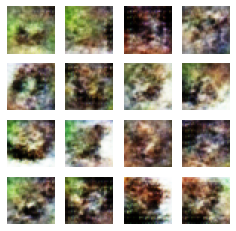

Time for training : 2981 sec


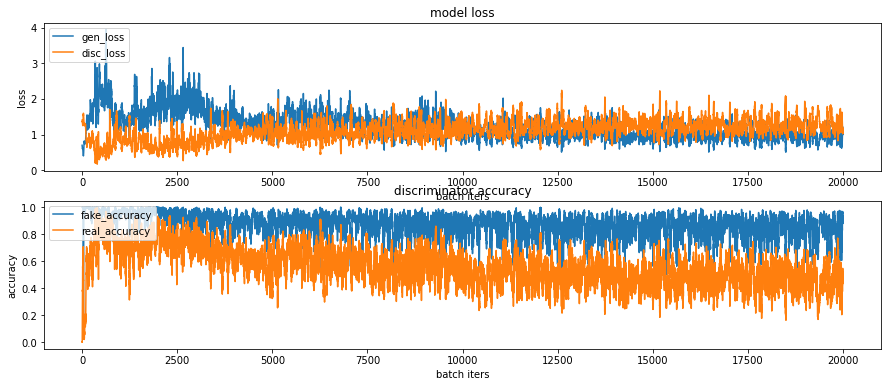

CPU times: user 49min 39s, sys: 1min 12s, total: 50min 52s
Wall time: 49min 43s


In [28]:
%%time
save_every = 5
EPOCHS = 2000

train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [29]:
# 진행과정을 gif 파일로 저장
anim_file = '/content/drive/MyDrive/AIFFEL/E11/cifar10/4.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/AIFFEL/E11/cifar10/generated_samples_4/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/AIFFEL/E11/cifar10/2.gif

-rw------- 1 root root 5547323 Aug 27 12:03 /content/drive/MyDrive/AIFFEL/E11/cifar10/2.gif


In [30]:
# 개구리 이미지
# epoch = 2000

display.Image(filename="/content/drive/MyDrive/AIFFEL/E11/cifar10/4.gif")

Output hidden; open in https://colab.research.google.com to view.

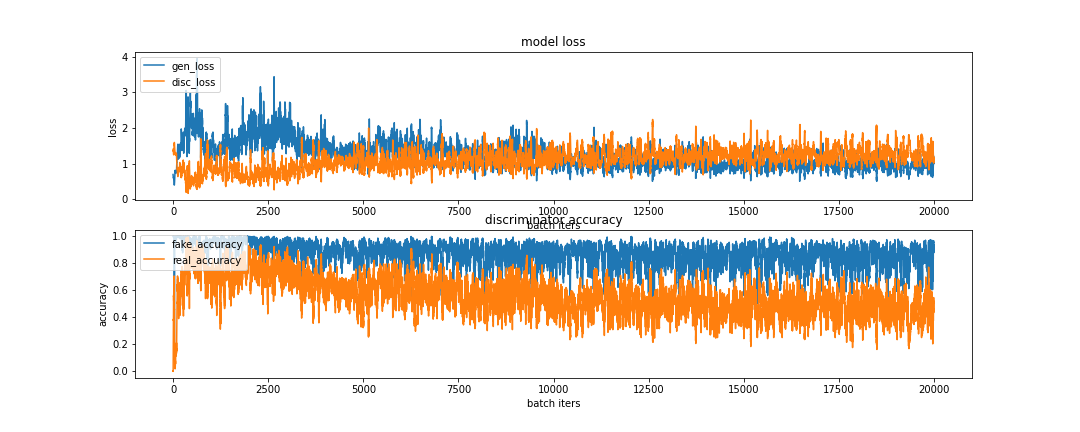

In [31]:
# 개구리 이미지 
# epoch = 2000
display.Image(filename='/content/drive/MyDrive/AIFFEL/E11/cifar10/training_history_4/train_history_0999.png')

개구리 이미지를 2000번 돌려보았지만 개구리인걸 모르고 있었으면 하나도 몰랐을 듯

## 다른 과정

In [32]:
# 고양이 이미지
# epoch = 1000
display.Image(filename="/content/drive/MyDrive/AIFFEL/E11/cifar10/3.gif")

Output hidden; open in https://colab.research.google.com to view.

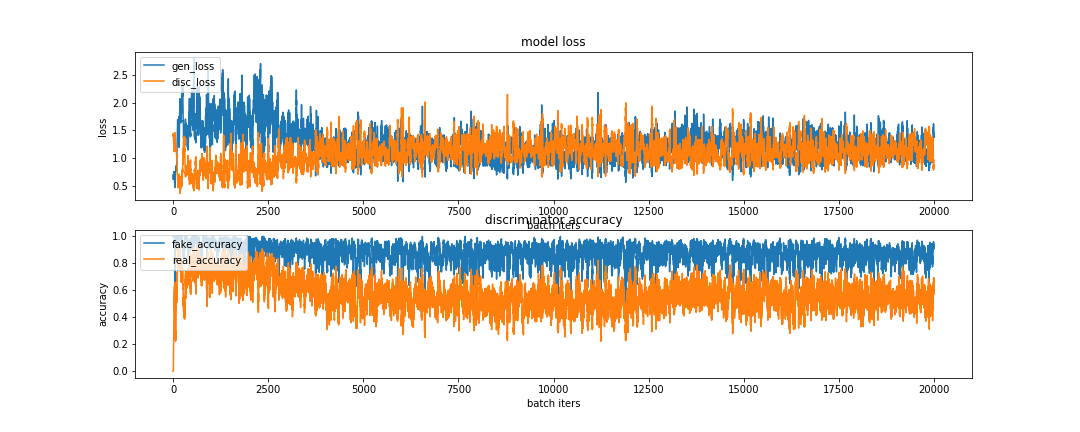

In [33]:
# 고양이 이미지
# epoch = 1000
display.Image(filename='/content/drive/MyDrive/AIFFEL/E11/cifar10/training_history_3/train_history_0999.png')

고양이 이미지로 데이터를 줄여서 시도 해봤지만 잘 못 알아보겠음

In [34]:
# 전체 이미지
# epoch = 1000
display.Image(filename="/content/drive/MyDrive/AIFFEL/E11/cifar10/2.gif")

Output hidden; open in https://colab.research.google.com to view.

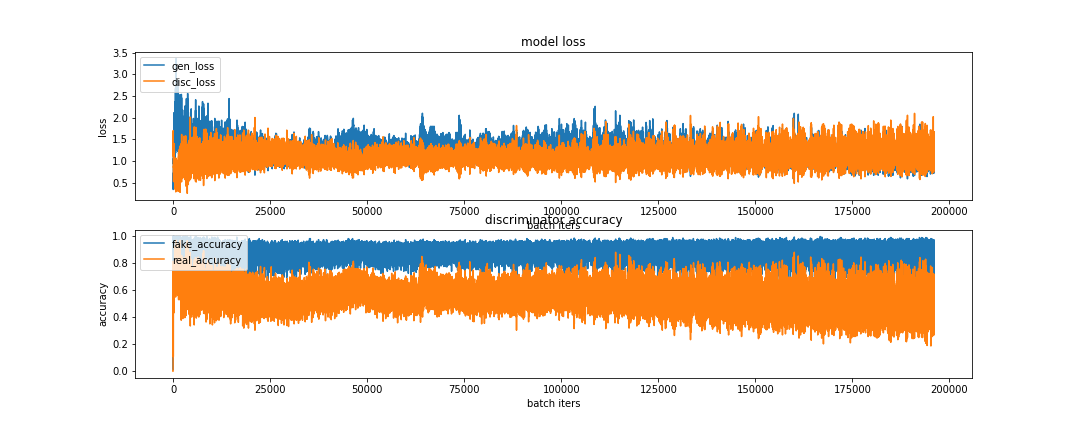

In [35]:
# 전체 이미지
# epoch = 1000
display.Image(filename='/content/drive/MyDrive/AIFFEL/E11/cifar10/training_history_2/train_history_0999.png')

전체 이미지를 1000번 돌리니 정확히 뭐다! 라고 하기엔 어렵지만 꽤 잘 만들어진 듯

In [36]:
# 전체 이미지
# epoch = 400
display.Image(filename="/content/drive/MyDrive/AIFFEL/E11/cifar10/1.gif")

Output hidden; open in https://colab.research.google.com to view.

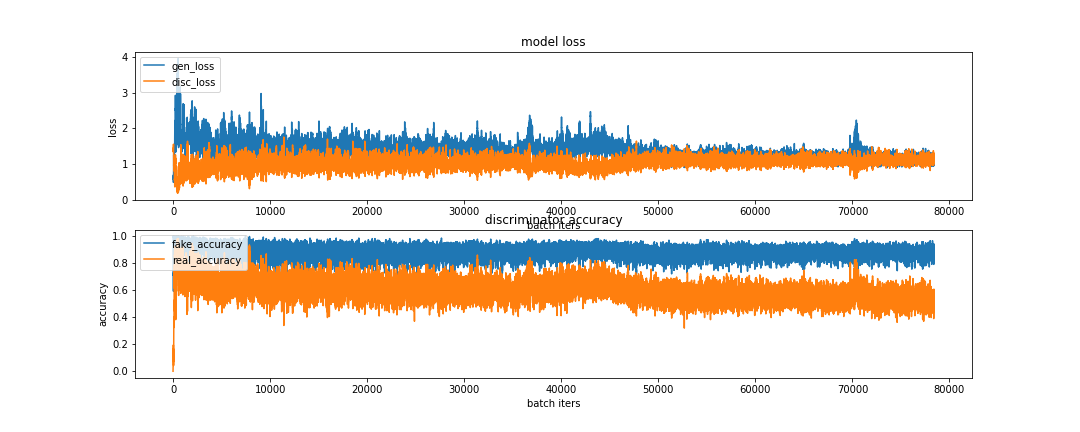

In [37]:
# 전체 이미지
# epoch = 400
display.Image(filename='/content/drive/MyDrive/AIFFEL/E11/cifar10/training_history_1/train_history_0399.png')

전체 이미지 400번 돌려보니 뚜렷히 보이는 건 없는듯

## 개선 사항
- DCGAN을 사용하면 효과가 있다고 함.
- 판별자에 SGD를 사용하고 생성자에 ADAM을 사용.
- 노이즈를 추가하는 것도 방법이라고 함.


## 회고
- 이미지가 생성되가는 게 신기함
- 개선 사항을 찾아봤지만 적용을 어떻게 시킬지 잘 모르겠음
- 전체 이미지를 사용했을 때와 한 종류의 이미지를 사용했을 때의 성능 차이가 심한 듯.. 